In [87]:
#import cv2
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import copy

landmarks = [11, 13]
landmarklocs = {11: [100, 300], 13: [300, 100]}

def norm(x, mu, sigma):
    return (1/(np.sqrt(2*np.pi)*sigma))*np.exp((-1/2)*(((x-mu)**2)/sigma**2))

class Particle():
    def __init__(self, x=0, y=0, theta=0, weight=0):
        self.x = x
        self.y = y
        self.theta = np.mod(theta, 360)
        self.weight = weight
    
    def initialize(self, maxX, maxY, minX=0, minY=0):
        self.x = random.random()+random.randint(minX, maxX-1)
        self.y = random.random()+random.randint(minY, maxY-1)
        self.theta = random.random()+random.randint(0, 359)
    
    def move(self, distance):
        distance += random.random()+(random.randint(-5, 4)*0.01*distance)
        self.x += math.cos(self.theta)*distance
        self.y += math.sin(self.theta)*distance

    def turn(self, degrees, right = True):
        degrees += random.random()*0.5+(random.randint(-5, 4)*0.005*degrees)
        self.theta += (int(right)*2-1)*degrees

    def getdist(self, x, y):
        return math.sqrt((x-self.x)**2+(y-self.y)**2)
    
    def getthetadiff(self, x, y): #given a landmarks' coordinates, returns the degrees between the particles theta and the theta if it looked towards the landmark
        vectorlandmark = [x-self.x, y-self.y]
        vectortheta = [math.sin(self.theta*math.pi/180), math.cos(self.theta*math.pi/180)]
        test = np.dot(vectortheta, vectorlandmark)
        return (180*math.acos(test/self.getdist(x, y))/math.pi) * (2*(int(vectorlandmark[0]>=0))-1)

def estimate_pose(particles_list):
    """Estimate the pose from particles by computing the average position and orientation over all particles. 
    This is not done using the particle weights, but just the sample distribution."""
    x_sum = 0.0
    y_sum = 0.0
    cos_sum = 0.0
    sin_sum = 0.0
     
    for particle in particles_list:
        x_sum += particle.x
        y_sum += particle.y
        cos_sum += np.cos(particle.theta*math.pi/180)
        sin_sum += np.sin(particle.theta*math.pi/180)
        
    flen = len(particles_list)
    if flen != 0:
        x = x_sum / flen
        y = y_sum / flen
        theta = 180*np.arctan2(sin_sum/flen, cos_sum/flen)/math.pi
    else:
        x = x_sum
        y = y_sum
        theta = 0.0
        
    return Particle(x, y, theta)

def jet(x):
    """Colour map for drawing particles. This function determines the colour of 
    a particle from its weight."""
    r = (x >= 3.0/8.0 and x < 5.0/8.0) * (4.0 * x - 3.0/2.0) + (x >= 5.0/8.0 and x < 7.0/8.0) + (x >= 7.0/8.0) * (-4.0 * x + 9.0/2.0)
    g = (x >= 1.0/8.0 and x < 3.0/8.0) * (4.0 * x - 1.0/2.0) + (x >= 3.0/8.0 and x < 5.0/8.0) + (x >= 5.0/8.0 and x < 7.0/8.0) * (-4.0 * x + 7.0/2.0)
    b = (x < 1.0/8.0) * (4.0 * x + 1.0/2.0) + (x >= 1.0/8.0 and x < 3.0/8.0) + (x >= 3.0/8.0 and x < 5.0/8.0) * (-4.0 * x + 5.0/2.0)

    return (255.0*r, 255.0*g, 255.0*b)

def draw_world(est_pose, particles, world):
    """Visualization.
    This functions draws robots position in the world coordinate system."""
    CRED = (0, 0, 255)
    CGREEN = (0, 255, 0)
    CBLUE = (255, 0, 0)
    CCYAN = (255, 255, 0)
    CYELLOW = (0, 255, 255)
    CMAGENTA = (255, 0, 255)
    CWHITE = (255, 255, 255)
    CBLACK = (0, 0, 0)
    landmark_colors = [CRED, CGREEN]

    # Fix the origin of the coordinate system
    offsetX = 100
    offsetY = 250

    # Constant needed for transforming from world coordinates to screen coordinates (flip the y-axis)
    ymax = world.shape[0]

    world[:] = CWHITE # Clear background to white

    # Find largest weight
    max_weight = 0
    for particle in particles:
        max_weight = max(max_weight, particle.weight)

    # Draw particles
    for particle in particles:
        x = int(particle.x + offsetX)
        y = ymax - (int(particle.y + offsetY))
        colour = jet(particle.weight / max_weight)
        cv2.circle(world, (x,y), 2, colour, 2)
        b = (int(particle.x + 15.0*np.cos(particle.theta))+offsetX, 
                                     ymax - (int(particle.y + 15.0*np.sin(particle.theta))+offsetY))
        cv2.line(world, (x,y), b, colour, 2)

    # Draw landmarks
    for i in range(len(landmarks)):
        ID = landmarks[i]
        lm = (int(landmarklocs[ID][0] + offsetX), int(ymax - (landmarklocs[ID][1] + offsetY)))
        cv2.circle(world, lm, 5, landmark_colors[i], 2)

    # Draw estimated robot pose
    a = (int(est_pose.x)+offsetX, ymax-(int(est_pose.y)+offsetY))
    b = (int(est_pose.x + 15.0*np.cos(est_pose.theta))+offsetX, 
                                 ymax-(int(est_pose.y + 15.0*np.sin(est_pose.theta))+offsetY))
    cv2.circle(world, a, 5, CMAGENTA, 2)
    cv2.line(world, a, b, CMAGENTA, 2)

#temp = Particle(0, 0, 0)

particlenumber = 3500
myparticles = []
for i in range(particlenumber):
    myparticles.append(Particle())
    myparticles[-1].initialize(500, 500)
#95% konfidensinterval for drejning er +- 2.5%
#95% konfidensinterval for kørsel er +- 5%
#robot = getArlo()

def getweightsdist(particles, dist, thetadiff, landmarkid):
    landmark = landmarklocs[landmarkid]
    weights = np.zeros(len(particles))
    for i in particles:
        weights[particles.index(i)] = max(0.000000001, norm(dist, i.getdist(landmark[0], landmark[1]), dist*0.05))
    #weights = weights/np.sum(weights)
    return getweightstheta(particles, thetadiff, landmarkid, weights)


def getweightstheta(particles, thetadiff, landmarkid, oldweights):

    weights = np.zeros(len(particles))
    landmark = landmarklocs[landmarkid]
    for i in particles:
        weights[particles.index(i)] = max(0.000000001, norm(thetadiff, i.getthetadiff(landmark[0], landmark[1]), 3))
    weights = weights*oldweights
    weights = weights/np.sum(weights)
    for i in range(len(particles)):
        particles[i].weight = weights[i]
    newparticles = []
    for i in range(len(particles)):
        newparticles.append(np.random.choice(particles, p=weights))
    return newparticles



resamples = getweightsdist(myparticles, 200, 0, 11)
bestparticle = estimate_pose(resamples)

for i in resamples:
    i.turn(90)

resamples2 = getweightsdist(copy.deepcopy(resamples), 200, 0, 13)
bestparticle = estimate_pose(resamples2)
print(bestparticle.x)
print(bestparticle.y)
print(bestparticle.theta)
#world = np.zeros((500,500,3), dtype=np.uint8)
#draw_world(bestparticle, myparticles, world)




134.3811369269512
70.73926218777204
86.97486869380843


{0.16191383843061458, 0.05432191302188755, 0.019472336372158783, 0.12938593612617938, 0.014231997119870832, 0.03863095796214172, 0.019572640996179284, 6.33812357213649e-05, 0.000997364924983873, 0.0016321075261573445, 0.08196559254503101, 0.10652950643630772, 0.11131214416638903, 0.004734667351686777, 0.013078521648422733, 0.0005156202998211817, 0.010802794287390859, 2.450657680310915e-05, 0.00010381826796276541, 0.0032371489413738613, 0.0019041916426064942, 0.007906157357797343, 0.06300213128056084, 0.07448005766582608, 0.00024393319145641075, 0.0034259103359113078, 0.0029583562952114418, 0.0006752170501961132, 0.00010162761692010301, 0.005303817160550714, 0.0032366684893956207, 0.00012777018587666552, 0.001864734059329845, 2.8024732921230994e-05, 0.05081154226691747, 0.004805780536581865, 0.003827507687320038, 0.0020167550873735327}


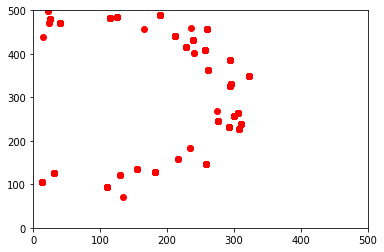

In [88]:
#for i in resamples:
#  plt.plot(i.x, i.y, 'ro')
plt.axis([0, 500, 0, 500])
print(set([x.weight for x in resamples]))
plt.plot([x.x for x in resamples], [x.y for x in resamples], 'ro')
plt.show()

{0.999929944602879}


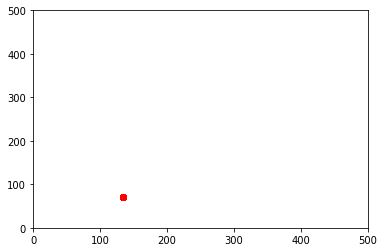

In [89]:
#for i in resamples:
#  plt.plot(i.x, i.y, 'ro')
print(set([x.weight for x in resamples2]))
plt.axis([0, 500, 0, 500])
plt.plot([x.x for x in resamples2], [x.y for x in resamples2], 'ro')
plt.show()